In [73]:
from pandas import read_csv
from datetime import datetime
import pandas as pd
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
#dataset = read_csv(r'D:\aa\Z\collectrate.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset = pd.read_csv(r'D:\aa\Z\spatiotemporalData.csv',
                                parse_dates=['Date'],
                                index_col=['Date'])
 
 
# summarize first 5 rows
print(dataset.head(5))
 # save to file
dataset.to_csv('pollution.csv')

                     C_pm25  B_pm25  B_pm10  B_co  D_pm25  D_pm10
Date                                                             
2021-03-12 00:00:00  269.67  203.59  322.91  1.14  106.69  412.00
2021-03-12 01:00:00  239.00  203.46  273.08  1.03  106.69  414.75
2021-03-12 02:00:00  214.33  204.77  236.94  1.05  106.69  402.50
2021-03-12 03:00:00  197.00  197.63  209.35  1.12  106.69  373.00
2021-03-12 04:00:00  216.67  201.15  223.85  1.11  106.69  319.00


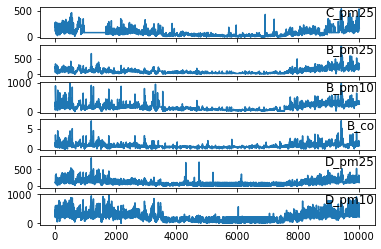

In [74]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4,5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
 pyplot.subplot(len(groups), 1, i)
 pyplot.plot(values[:, group])
 pyplot.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
pyplot.show()

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)
1   0.493879   0.224442   0.319853   0.163793   0.314033   0.422405
2   0.437500   0.224296   0.267903   0.147988   0.314033   0.425231
3   0.392151   0.225765   0.230226   0.150862   0.314033   0.412641
4   0.360294   0.217761   0.201462   0.160920   0.314033   0.382323
5   0.396452   0.221707   0.216579   0.159483   0.314033   0.326824
(8760, 1, 5) (8760,) (1262, 1, 5) (1262,)
Epoch 1/50
122/122 - 2s - loss: 0.1058 - val_loss: 0.0948 - 2s/epoch - 13ms/step
Epoch 2/50
122/122 - 0s - loss: 0.0548 - val_loss: 0.0642 - 165ms/epoch - 1ms/step
Epoch 3/50
122/122 - 0s - loss: 0.0510 - val_loss: 0.0649 - 167ms/epoch - 1ms/step
Epoch 4/50
122/122 - 0s - loss: 0.0495 - val_loss: 0.0657 - 151ms/epoch - 1ms/step
Epoch 5/50
122/122 - 0s - loss: 0.0490 - val_loss: 0.0662 - 166ms/epoch - 1ms/step
Epoch 6/50
122/122 - 0s - loss: 0.0488 - val_loss: 0.0662 - 151ms/epoch - 1ms/step
Epoch 7/50
122/122 - 0s - loss: 0.0487 - val_loss: 0.0

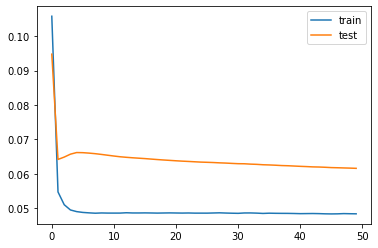

40/40 [==============================] - 0s 820us/step


In [75]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))


In [76]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 0:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 0:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 43.334


In [77]:
inv_yhat

array([238.30255, 200.81436, 215.45966, ..., 212.03397, 195.99985,
       155.88576], dtype=float32)